In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

import tqdm;
from tqdm.auto import tqdm;

d:\Cinthia\env_modelos\venv2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#SOLO EJECUTAR UNA VEZ POR DIA
INTENTO=1

In [3]:
# Make a device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
#GPUS
n_gpus = torch.cuda.device_count()
print(f"Number of gpus: {n_gpus}")

Number of gpus: 1


In [5]:
class ConvBlock (nn.Module):
    def __init__(self,
                in_channels: int,
                out_channels: int,
                 **kwargs): # this means that the key arguments are arbitrary
        super().__init__()

        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels=in_channels,
                            out_channels=out_channels,
                              **kwargs,
                            device=device)
        self.batchnorm = nn.BatchNorm2d(num_features=out_channels) # to improve performance
    
    def forward(self,x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x

In [6]:
class L2NormLayer(nn.Module):
    def __init__(self,dim=1):
        super().__init__()
        self.dim=dim
    
    def forward(self,x):
        return nn.functional.normalize(x,p=2,dim=self.dim)

In [7]:
class InceptionBlock (nn.Module):
        def __init__(self,
                in_channels: int,
                out_1x1: int,

                red_3x3: int,
                out_3x3: int,

                red_5x5: int,
                out_5x5: int,

                out_1x1pool: int,
                
                l2_mode:bool=False):
        
                super().__init__()

                self.branch1 = ConvBlock(in_channels=in_channels,
                                        out_channels=out_1x1,
                                        kernel_size=1)
                
                self.branch2 = nn.Sequential(
                        ConvBlock(in_channels=in_channels,
                                out_channels=red_3x3,
                                kernel_size=1),
                        ConvBlock(in_channels=red_3x3,
                                out_channels=out_3x3,
                                kernel_size=3,
                                padding=1) 
                )
                
                self.branch3 = nn.Sequential(
                        ConvBlock(in_channels=in_channels,
                                out_channels=red_5x5,
                                kernel_size=1),
                        ConvBlock(in_channels=red_5x5,
                                out_channels=out_5x5,
                                kernel_size=5,
                                padding=2)
                )

                if l2_mode:
                        self.branch4=nn.Sequential(
                                L2NormLayer(dim=1),
                                ConvBlock(in_channels=in_channels,
                                out_channels=out_1x1pool,
                                kernel_size=1)
                        )
                else:
                        self.branch4 = nn.Sequential(
                                nn.MaxPool2d(kernel_size=3,stride=1,padding=1),
                                ConvBlock(in_channels=in_channels,
                                        out_channels=out_1x1pool,
                                        kernel_size=1)
                        )

        def forward(self,x):
        # N x filters x 28 x 28 → 0th x 1st x 2nd x 3rd dimension (we use 1)
                return torch.cat([self.branch1(x),self.branch2(x),self.branch3(x),self.branch4(x)],1)

In [8]:
class InceptionBlock_2(nn.Module):
    def __init__(self, 
                in_channels:int, 
                red_3x3:int,
                out_3x3:int) -> None:
        super().__init__()
        self.branch=nn.Sequential(
            ConvBlock(in_channels=in_channels,
                    out_channels=red_3x3,
                    kernel_size=1),
            ConvBlock(in_channels=red_3x3,
                    out_channels=out_3x3,
                    kernel_size=3)
        )
    def forward(self,x):
        return self.branch(x)

In [9]:
class InceptionBlock_m_3x3 (nn.Module):
        def __init__(self,
                in_channels: int,

                red_3x3: int,
                out_3x3: int,

                red_5x5: int,
                out_5x5: int):
        
                super().__init__()

                self.branch2 = nn.Sequential(
                        ConvBlock(in_channels=in_channels,
                                out_channels=red_3x3,
                                kernel_size=1),
                        ConvBlock(in_channels=red_3x3,
                                out_channels=out_3x3,
                                kernel_size=3,
                                padding=1,
                                stride=2) # ojo (btw no ponemos el S bc por defecto es 1)
                )
                
                self.branch3 = nn.Sequential(
                        ConvBlock(in_channels=in_channels,
                                out_channels=red_5x5,
                                kernel_size=1),
                        ConvBlock(in_channels=red_5x5,
                                out_channels=out_5x5,
                                kernel_size=5,
                                padding=2,
                                stride=2) # ojo (btw no ponemos el S bc por defecto es 1)
                )

                self.branch4 = nn.Sequential(
                        nn.MaxPool2d(kernel_size=3,stride=2,padding=1), 
                )

        def forward(self,x):
        # N x filters x 28 x 28 → 0th x 1st x 2nd x 3rd dimension (we use 1)
                return torch.cat([self.branch2(x),self.branch3(x),self.branch4(x)],1)

## Structure of the Model

In [10]:
class NN2 (nn.Module):
    def __init__(self,
                in_channels = 3):
        super().__init__()

        self.conv1 = ConvBlock(in_channels=in_channels,
                            out_channels=64,
                            kernel_size=7,
                            stride=2,
                            padding=3)
        
        self.inception2 = InceptionBlock_2(in_channels=64, #la cantidad de canales que entran y salen es la misma. ¿esto es correcto?
                                        red_3x3=64,
                                        out_3x3=192)
    
        self.inception3a = InceptionBlock( in_channels= 192, out_1x1= 64, red_3x3= 96, out_3x3= 128, red_5x5= 16,out_5x5= 32, out_1x1pool= 32)#ok
        self.inception3b = InceptionBlock( in_channels= 256, out_1x1= 64, red_3x3= 96, out_3x3= 128, red_5x5= 32,out_5x5= 64, out_1x1pool= 64,l2_mode=True)
        #modificar desactivando branch 1 y 4
        self.inception3c = InceptionBlock_m_3x3( in_channels= 320, red_3x3= 128, out_3x3= 256, red_5x5= 32,out_5x5= 64)
        
        self.inception4a = InceptionBlock( in_channels= 640, out_1x1= 256, red_3x3= 96, out_3x3= 192, red_5x5= 32,out_5x5= 64, out_1x1pool= 128,l2_mode=True)
        self.inception4b = InceptionBlock( in_channels= 640, out_1x1= 224, red_3x3= 112, out_3x3= 224, red_5x5= 32,out_5x5= 64, out_1x1pool= 128,l2_mode=True)
        self.inception4c = InceptionBlock( in_channels= 640, out_1x1= 192, red_3x3= 128, out_3x3= 256, red_5x5= 32,out_5x5= 64, out_1x1pool= 128,l2_mode=True)
        self.inception4d = InceptionBlock( in_channels= 640, out_1x1= 160, red_3x3= 144, out_3x3= 288, red_5x5= 32,out_5x5= 64, out_1x1pool= 128,l2_mode=True)
        #modificar desactivando branch 1 y 4
        self.inception4e = InceptionBlock_m_3x3( in_channels= 640, red_3x3= 160, out_3x3= 256, red_5x5= 64,out_5x5= 128)
        
        self.inception5a = InceptionBlock( in_channels= 1024, out_1x1= 384, red_3x3= 192, out_3x3= 384, red_5x5= 48,out_5x5= 128, out_1x1pool= 128,l2_mode=True)
        self.inception5b = InceptionBlock( in_channels= 1024, out_1x1= 384, red_3x3= 192, out_3x3= 384, red_5x5= 48,out_5x5= 128, out_1x1pool= 128)#ok
        
        self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1) #por que se aplico un max pool?

        self.avgpool = nn.AvgPool2d(kernel_size=7) # stride? padding?
        
        self.FC = nn.Linear(1024,128)

        self.norm=nn.BatchNorm2d(num_features=64)


    def forward(self,x):
        x = self.conv1(x)
        x = self.maxpool(x)

        x=self.norm(x)

        x = self.inception2(x)
        x = self.maxpool(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.inception3c(x)

        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)

        x = self.inception5a(x)
        x = self.inception5b(x)
        #print('Despues del inception 5b',x.shape)
        x = self.avgpool(x)
        #print('Despues del avg pool',x.shape)

        x=x.view(x.shape[0],-1)

        x = self.FC(x)
        #print('Despues de fully connected layer',x.shape)
        x = nn.functional.normalize(x,p=2,dim=1)

        return x

## Transform

In [11]:
transform=transforms.Compose([
    transforms.Resize((224,224)),  #Para pasar a 224 x 224 pixels
    transforms.ToTensor()          #Para convertir la imagen a tensor
])

## Path of dataset

In [12]:
import os

print(os.getcwd())

d:\Cinthia\env_modelos


In [13]:
from pathlib import Path

root_data_path=Path('data')
train_path=root_data_path / 'train'

test_path=root_data_path / 'test'

train_path

WindowsPath('data/train')

In [14]:
img_path_list=list(test_path.glob('*/*.jpg'))

import random
from PIL import Image

random_image_path=random.choice(img_path_list)
img=Image.open(random_image_path)

transform(img).shape

torch.Size([3, 224, 224])

In [15]:
train_data=torchvision.datasets.ImageFolder(train_path,
                                        transform=transform,
                                        target_transform=None)

test_data=torchvision.datasets.ImageFolder(test_path,
                                        transform=transform)

In [16]:
train_data.samples

[('data\\train\\Brayan\\a_rostro_1.jpg', 0),
 ('data\\train\\Brayan\\a_rostro_102.jpg', 0),
 ('data\\train\\Brayan\\a_rostro_109.jpg', 0),
 ('data\\train\\Brayan\\a_rostro_113.jpg', 0),
 ('data\\train\\Brayan\\a_rostro_120.jpg', 0),
 ('data\\train\\Brayan\\a_rostro_124.jpg', 0),
 ('data\\train\\Brayan\\a_rostro_131.jpg', 0),
 ('data\\train\\Brayan\\a_rostro_137.jpg', 0),
 ('data\\train\\Brayan\\a_rostro_145.jpg', 0),
 ('data\\train\\Brayan\\a_rostro_146.jpg', 0),
 ('data\\train\\Brayan\\a_rostro_16.jpg', 0),
 ('data\\train\\Brayan\\a_rostro_163.jpg', 0),
 ('data\\train\\Brayan\\a_rostro_170.jpg', 0),
 ('data\\train\\Brayan\\a_rostro_176.jpg', 0),
 ('data\\train\\Brayan\\a_rostro_183.jpg', 0),
 ('data\\train\\Brayan\\a_rostro_185.jpg', 0),
 ('data\\train\\Brayan\\a_rostro_194.jpg', 0),
 ('data\\train\\Brayan\\a_rostro_200.jpg', 0),
 ('data\\train\\Brayan\\a_rostro_210.jpg', 0),
 ('data\\train\\Brayan\\a_rostro_238.jpg', 0),
 ('data\\train\\Brayan\\a_rostro_239.jpg', 0),
 ('data\\train\\

## Split the data

In [17]:
train_data.class_to_idx

{'Brayan': 0,
 'Carlos_Cruz': 1,
 'Carlos_Pacherres': 2,
 'Cinthia': 3,
 'Eduardo_Crisanto': 4,
 'Elvis': 5,
 'Irene_Alvarado': 6,
 'Pamela': 7,
 'Rodrigo': 8,
 'William': 9,
 'William_Ipanaque': 10}

In [18]:
def get_val_far_metrics(anchors,positives,negatives,treshold=0.5):

    count_FA=0
    count_TA=0
    
    count_P=anchors.size(0)


    for a,p,n in zip(anchors,positives,negatives):
        d1 = torch.norm(a - p, p=2) 
        d2 = torch.norm(a - n, p=2) 
        if d1 < treshold:
            count_TA+=1

        if d2 < treshold:
            count_FA+=1

    if count_P == 0:
        return 0,0
    else:
        val_metric=count_TA/count_P

        far_metric=count_FA/count_P

        return val_metric,far_metric

In [52]:
def train_step(
        model:torch.nn.Module,
        dataloader:torch.utils.data.dataloader,
        loss_fn,
        optimizer:torch.optim.Optimizer,
        mining_func,
        treshold:int,
        device):
    
    model.train()

    train_loss,train_val,train_far=0,0,0

    for batch, (X,y) in enumerate(dataloader):
        #Send data to the target device
        X,y=X.to(device),y.to(device)

        #1. Forward pass
        embeddings=model(X) #Output model logits

        indices_tuple=mining_func(embeddings,y)

        #2. Calculate the loss

        anchors=embeddings[indices_tuple[0]]
        positives=embeddings[indices_tuple[1]]
        negatives=embeddings[indices_tuple[2]]

        loss=loss_fn(embeddings,y,indices_tuple)

        loss=torch.nan_to_num(loss,nan=0.0)

        train_loss+=loss.item()

        #3.Optimizer zero grad
        optimizer.zero_grad()

        #4. Loss backward
        loss.backward()

        #5. Optimizer step
        optimizer.step()

        #Calculate VAL and FAR metrics

        val_metric,far_metric=get_val_far_metrics(anchors=anchors,positives=positives,negatives=negatives,treshold=treshold)

        train_val+=val_metric
        train_far+=far_metric

    #Adjust metrics to get average loss and accuracy per batch
    train_loss= train_loss/len(dataloader)
    train_val=train_val / len(dataloader)
    train_far=train_far / len(dataloader)
    
    #return train_loss,train_acc
    return train_loss,train_val,train_far

In [57]:
def test_step(
        model:torch.nn.Module,
        dataloader:torch.utils.data.dataloader,
        loss_fn,
        mining_func,
        treshold:int,
        device=device):
    
    #Put model in eval mode
    model.eval()
    print('---------------------------')
    print('EPOCH TEST')
    test_loss,test_val,test_far=0,0,0

    with torch.inference_mode():
        #Loop through DataLoader batches

        for batch, (X,y) in enumerate(dataloader):
            #Send data to the target device
            X,y=X.to(device),y.to(device)

            #1. Forward pass
            embeddings=model(X)

            indices_tuple=mining_func(embeddings,y)

            anchors=embeddings[indices_tuple[0]]
            positives=embeddings[indices_tuple[1]]
            negatives=embeddings[indices_tuple[2]]

            #2. Calculate the loss
            loss=loss_fn(embeddings,y,indices_tuple)

            loss=torch.nan_to_num(loss,nan=0.0)

            test_loss+=loss.item()

            #3. Calculate VAL and FAR metrics

            val_metric,far_metric=get_val_far_metrics(anchors=anchors,positives=positives,negatives=negatives,treshold=treshold)
            print('FAR metric value: ',far_metric)
            test_val+=val_metric
            test_far+=far_metric
        


    #Adjust the metrics to get averague loss and accuracy per batch
    test_loss=test_loss / len(dataloader)
    test_loss=test_val / len(dataloader)
    test_loss=test_far / len(dataloader)

    #return test_loss,test_acc
    return test_loss,test_val,test_far

In [58]:
def train_model(model:torch.nn.Module,
        train_dataloader:torch.utils.data.dataloader,
        test_dataloader:torch.utils.data.dataloader,
        optimizer:torch.optim.Optimizer,
        loss_fn,
        minig_func,
        lr_scheduler:torch.optim.lr_scheduler,
        treshold:int,
        epochs=5,
        device=device):

        #2. Create empty results dictionary
        # results={"train_loss":[],
        #         "train_acc":[],
        #         "test_loss":[],
        #         "test_acc":[]}

        results={"train_loss":[],
                "test_loss":[],
                "train_val":[],
                "test_val":[],
                "train_far":[],
                "test_far":[],}
        
                #3. Loop through training and testing step for a number of epochs
        for epoch in tqdm(range(epochs)):
                train_loss,train_val,train_far=train_step(model=model,
                                dataloader=train_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                mining_func=minig_func,
                                treshold=treshold,
                                device=device)
                test_loss,test_val,test_far=test_step(model=model,
                                dataloader=test_dataloader,
                                loss_fn=loss_fn,
                                mining_func=minig_func,
                                treshold=treshold,
                                device=device)

                lr_scheduler.step(test_loss)

                #4. Print out what's happening
                print(f"Epoch: {epoch} | Train loss:{train_loss:.4f} | Test loss : {test_loss:.4f}")
                print(f"Epoch: {epoch} | Train val:{train_val:.4f}  | Test val : {test_val:.4f}")
                print(f"Epoch: {epoch} | Train far:{train_far:.4f}  | Test far : {test_far:.4f}")
                #5. Update results diccionary
                results["train_loss"].append(train_loss)
                results["test_loss"].append(test_loss)
                results["train_val"].append(train_val)
                results["test_val"].append(test_val)
                results["train_far"].append(train_far)
                results["test_far"].append(test_far)

        return results

In [59]:
from typing import Dict,List

def plot_loss_curves(results:Dict[str,List[float]],dir):
    """
    Plots training curves of a results dictionary.
    """
    #Get the loss values of the results dictionary (training and test)
    train_loss=results["train_loss"]
    test_loss=results["test_loss"]

    #Get the val values of the results dictionary (training and test)
    train_val=results["train_val"]
    test_val=results["test_val"]

    #Get the far values of the results dictionary (training and test)
    train_far=results["train_far"]
    test_far=results["test_far"]

    #Figure out how many epochs there where
    epochs=range(len(results["train_loss"]))

    plt.figure(figsize=(15,7))

    #Plot the loss
    plt.subplot(1,3,1)
    plt.plot(epochs,train_loss,label='train_loss')
    plt.plot(epochs,test_loss,label='test_loss')
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    #Plot the VAL
    plt.subplot(1,3,2)
    plt.plot(epochs,train_val,label='train_val')
    plt.plot(epochs,test_val,label='test_val')
    plt.title("VAL")
    plt.xlabel("Epochs")
    plt.legend()

    #Plot the FAR
    plt.subplot(1,3,3)
    plt.plot(epochs,train_far,label='train_far')
    plt.plot(epochs,test_far,label='test_far')
    plt.title("FAR")
    plt.xlabel("Epochs")
    plt.legend()
    plt.savefig(dir)

### ♦ Hyper parameters

In [60]:
from enum import Enum
class HyperParameters(Enum):
    BATCH_SIZE=32
    NUM_EPOCHS=1
    LR=0.01
    TRIPLE_LOSS_MARGIN=0.2
    TYPE_OF_TRIPLETS='hard'
    LR_SCHEDULER_PATIENCE=10
    TRESHOLD_METRICS=0.4


In [61]:
train_loader=DataLoader(dataset=train_data,
                        batch_size=HyperParameters.BATCH_SIZE.value,
                        num_workers=2,
                        shuffle=True)

test_loader=DataLoader(dataset=test_data,
                        batch_size=HyperParameters.BATCH_SIZE.value,
                        num_workers=2,
                        shuffle=False)

### PyTorch-Metric-Learning stuff

**Distance:** With a similarity measure, the TripletMarginLoss internally swaps the anchor-positive and anchor-negative terms: [san - sap + margin]+. In other words, it will try to make the anchor-negative similarities smaller than the anchor-positive similarities.

> The returned mat[i,j] is the cosine similarity between query_emb[i] and ref_emb[j]. This class is equivalent to DotProductSimilarity(normalize_embeddings=True).

**Reducer:** This computes the average loss, using only the losses that are greater than 0. For example, if the losses are [0, 2, 0, 3], then this reducer will return 2.5.

`reducers.AvgNonZeroReducer(**kwargs)`

This class is equivalent to using ThresholdReducer(low=0). See ThresholdReducer.

> *ThresholdReducer*: This computes the average loss, using only the losses that fall within a specified range.

In [62]:
from pytorch_metric_learning import losses,distances,reducers,regularizers
from pytorch_metric_learning.miners import TripletMarginMiner

# (1) loss_fn=nn.TripletMarginLoss(margin=HyperParameters.TRIPLE_LOSS_MARGIN.value,p=2)
# (2) loss_func = losses.TripletMarginLoss(distance = CosineSimilarity(), 
#                                     reducer = ThresholdReducer(high=0.3), 
#                                     embedding_regularizer = LpRegularizer())

# (3) loss_func=losses.TripletMarginLoss(margin=0.2)

distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low=0)
loss_func = losses.TripletMarginLoss(margin=0.2,distance=distance,reducer=reducer)



In [63]:
model_1 = NN2(in_channels=3).to(device)

optimizer=optim.Adam(params=model_1.parameters(),
                    lr=0.001)

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                    patience=HyperParameters.LR_SCHEDULER_PATIENCE.value)

In [64]:
minig_func=TripletMarginMiner(margin=0.2,distance=distance,type_of_triplets=HyperParameters.TYPE_OF_TRIPLETS.value)

In [65]:
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    """Print diff between start and end time:"""
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

from playsound import playsound
def notification():
    playsound('data\sound_notif.mp3')

In [66]:
# Start measuring time
from timeit import default_timer as timer
train_time_start_model = timer()

results_model_1=train_model(
    model=model_1,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    optimizer=optimizer,
    loss_fn=loss_func,
    minig_func=minig_func,
    lr_scheduler=lr_scheduler,
    treshold=HyperParameters.TRESHOLD_METRICS.value,
    epochs=HyperParameters.NUM_EPOCHS.value,
    device=device
)

# End measuring time
train_time_end_model = timer()
# Print it!
total_train_time_model = print_train_time(start=train_time_start_model,
                                            end=train_time_end_model,
                                            device=device)

notification()

  0%|          | 0/1 [00:00<?, ?it/s]

FAR metric value:  0
FAR metric value:  0
FAR metric value:  0
FAR metric value:  0
FAR metric value:  0
FAR metric value:  0
FAR metric value:  1.0
FAR metric value:  0
FAR metric value:  0
FAR metric value:  0
FAR metric value:  0
FAR metric value:  0
FAR metric value:  1.0
FAR metric value:  0
FAR metric value:  0
FAR metric value:  1.0
FAR metric value:  0
FAR metric value:  0
FAR metric value:  0
FAR metric value:  0
FAR metric value:  0
FAR metric value:  0
FAR metric value:  0
FAR metric value:  0
FAR metric value:  0
FAR metric value:  0
FAR metric value:  0
FAR metric value:  0
FAR metric value:  0
FAR metric value:  0
FAR metric value:  0
FAR metric value:  0
FAR metric value:  0
FAR metric value:  0
FAR metric value:  0


100%|██████████| 1/1 [00:50<00:00, 50.43s/it]

Epoch: 0 | Train loss:0.1840 | Test loss : 0.0857
Epoch: 0 | Train val:0.9058  | Test val : 3.0000
Epoch: 0 | Train far:0.9112  | Test far : 3.0000
Train time on cuda: 50.430 seconds


## SAVE THE MODEL

In [49]:
from datetime import date

day=date.today().strftime('%Y_%m_%d')

day

'2024_08_27'

In [50]:
INTENTO=5

Saving model to: models_cinthia\2024_08_27\5\model_30_epochs.pth


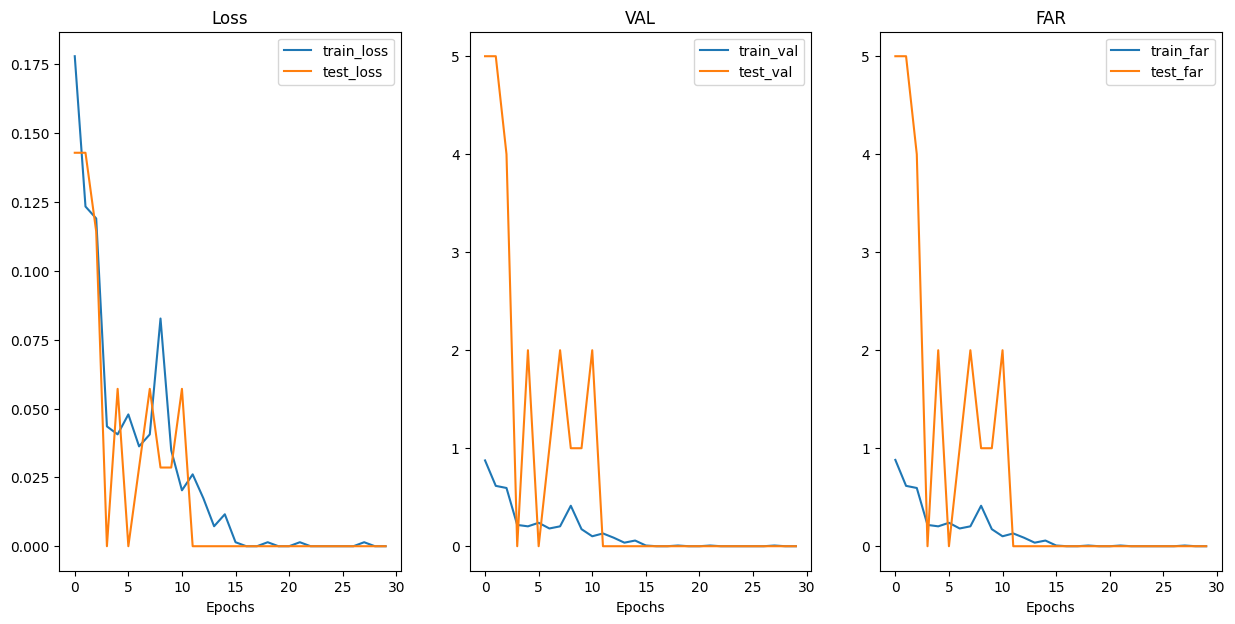

In [51]:
from datetime import date

#Create model directory path
MODEL_PATH=Path('models_cinthia')
MODEL_PATH.mkdir(parents=True,
                exist_ok=True)

DAY=date.today().strftime('%Y_%m_%d')

DAY_PATH=MODEL_PATH/DAY

DAY_PATH.mkdir(parents=True,
        exist_ok=True)

INTENTO_PATH=DAY_PATH/str(INTENTO)

INTENTO_PATH.mkdir(parents=True,
        exist_ok=True)

INTENTO+=1

#Create model save
MODEL_NAME=f'model_{HyperParameters.NUM_EPOCHS.value}_epochs.pth'
MODEL_SAVE_PATH=INTENTO_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
        f=MODEL_SAVE_PATH)

PATH_SETTINGS=INTENTO_PATH/'settings.txt'
with open(PATH_SETTINGS,'w') as f:
        for param in HyperParameters:
                row=f"{param.name} : {param.value} \n"
                f.writelines(row)


plot_loss_curves(results_model_1,dir=INTENTO_PATH/'metrics_graphic.png')
